## Spot Analysis

Originally written by Alex Broughton



In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_14/conda/envs/lsst-scipipe-3.0.0-ext/eups 	setup
lsst_distrib          g4eaec17cb9+23bdaa02ee 	w_latest w_2022_14 current setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.obs.lsst import LsstCam
from lsst.afw.cameraGeom.utils import findAmp
from lsst.geom import Point2I
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
import logging


logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [22]:
import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import Analyzer, readData, getSensorData

sensor2det = { "RO2_S00" : 9,
               "R03_S12" : 23,
               "R21_S02" : 83,
               "R24_S11" : 112 }
              

#### Read Data

In [23]:
outdir = "/sdf/home/a/abrought/run5/BF/data/new/"
sensor = "R03_S12"
detector = sensor2det[sensor]
wavelength = "450nm"

ellipse = False

if ellipse:
    uncorrected = sorted(glob.glob(outdir + "*" + sensor + "*_ellipse_*" + wavelength + "*_uncorrected.pkl"))
    corrected = sorted(glob.glob(outdir + "*" + sensor + "*_ellipse_*" + wavelength + "*_corrected.pkl"))
else:
    uncorrected = sorted(glob.glob(outdir + "*" + sensor + "*" + wavelength + "*_uncorrected.pkl"))
    corrected = sorted(glob.glob(outdir + "*" + sensor + "*" + wavelength + "*_corrected.pkl"))

if len(uncorrected) == 0:
    print("No files found.")
else:
    print("UNCORRECTED:", len(uncorrected), "/ 2\n", uncorrected)
    print()
    print("CORRECTED:", len(corrected), "/ 2\n", corrected)

UNCORRECTED: 2 / 2
 ['/sdf/home/a/abrought/run5/BF/data/new/data_13232_R03_S12_2022-06-16T15:49:50_450nm_uncorrected.pkl', '/sdf/home/a/abrought/run5/BF/data/new/data_13234_R03_S12_2022-06-16T16:13:27_450nm_uncorrected.pkl']

CORRECTED: 2 / 2
 ['/sdf/home/a/abrought/run5/BF/data/new/data_13232_R03_S12_2022-06-16T15:59:39_450nm_corrected.pkl', '/sdf/home/a/abrought/run5/BF/data/new/data_13234_R03_S12_2022-06-16T16:27:53_450nm_corrected.pkl']


In [24]:
print("UNCORRECTED\n")
data_uncorrected = readData( uncorrected[0], uncorrected[1], expstoremove=1)

print("\n\n")

print("CORRECTED\n")
data_corrected = readData( corrected[0], corrected[1], expstoremove=1)


UNCORRECTED

File 1
15.0s, 16 images
17.5s, 20 images
20.0s, 20 images
22.5s, 20 images
25.0s, 20 images
27.5s, 20 images
30.0s, 20 images
32.5s, 20 images
35.0s, 20 images
37.5s, 20 images
40.0s, 20 images
42.5s, 20 images
45.0s, 20 images
47.5s, 20 images
50.0s, 20 images


File 2
1.25s, 36 images
2.5s, 40 images
3.75s, 40 images
5.0s, 40 images
6.25s, 40 images
7.5s, 40 images
8.75s, 40 images
10.0s, 40 images
11.25s, 40 images
12.5s, 40 images


Combined
1.25s, 36 images
2.5s, 40 images
3.75s, 40 images
5.0s, 40 images
6.25s, 40 images
7.5s, 40 images
8.75s, 40 images
10.0s, 40 images
11.25s, 40 images
12.5s, 40 images
15.0s, 16 images
17.5s, 20 images
20.0s, 20 images
22.5s, 20 images
25.0s, 20 images
27.5s, 20 images
30.0s, 20 images
32.5s, 20 images
35.0s, 20 images
37.5s, 20 images
40.0s, 20 images
42.5s, 20 images
45.0s, 20 images
47.5s, 20 images
50.0s, 20 images



CORRECTED

File 1
15.0s, 16 images
17.5s, 20 images
20.0s, 20 images
22.5s, 20 images
25.0s, 20 images
27.5s, 2

Text(0.5, 0, 'MJD')

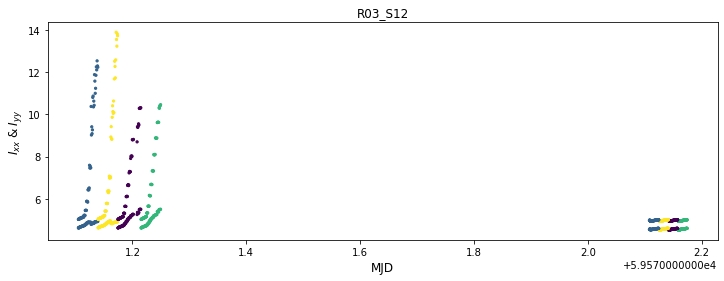

In [26]:
xx = []
yy = []
mjd = []
exptime = []
botx = []
boty = []
size = []

for t in data_uncorrected:
    xx.append(np.nanmedian(t['base_SdssShape_xx']))
    yy.append(np.nanmedian(t['base_SdssShape_yy']))
    size.append(len(t['base_SdssCentroid_x']))
    mjd.append(t['MJD'])
    botx.append(t['BOTX'])
    boty.append(t['BOTY'])
    exptime.append(t['exptime'])

plt.figure(figsize=(12,4), facecolor='white')
plt.title(sensor, fontsize=12)
sca = plt.scatter(mjd, xx, c=np.array(botx)/np.array(boty), s=5)
sca = plt.scatter(mjd, yy, c=np.array(botx)/np.array(boty), s=5)
#plt.scatter(mjd, yy, c=np.asarray(botx)/np.asarray(boty), s=5)
#plt.xlim(0.900,1.100)
#plt.ylim(4.9,5.5)
#plt.colorbar(sca, label="BOT pos (unitless)")
plt.ylabel(r'$I_{xx}\;&\;I_{yy}$', rotation=90, fontsize=12, loc='center')
plt.xlabel("MJD", fontsize=12)

## dT = T - Tn Plot

In [27]:
ptc_turnoffs, cti_turnoffs, mos, gains, gains_linearized, _ = getSensorData(sensor=sensor, detector=detector)




In [10]:
data_corrected = readData( outdir + "data_13239_R24_S11_2022-06-13T11:28:05_450nm_corrected.pkl", \
                 outdir + "data_13240_R24_S11_2022-06-13T12:01:29_450nm_corrected.pkl", \
                 expstoremove=0)

File 1
1.25s, 40 images
2.5s, 40 images
3.75s, 40 images
5.0s, 40 images
6.25s, 40 images
7.5s, 40 images
8.75s, 40 images
10.0s, 40 images
11.25s, 40 images
12.5s, 40 images


File 2
15.0s, 20 images
17.5s, 20 images
20.0s, 20 images
22.5s, 20 images
25.0s, 20 images
27.5s, 20 images
30.0s, 20 images
32.5s, 20 images
35.0s, 20 images
37.5s, 20 images
40.0s, 20 images
42.5s, 20 images
45.0s, 20 images
47.5s, 20 images
50.0s, 20 images


Combined
1.25s, 40 images
2.5s, 40 images
3.75s, 40 images
5.0s, 40 images
6.25s, 40 images
7.5s, 40 images
8.75s, 40 images
10.0s, 40 images
11.25s, 40 images
12.5s, 40 images
15.0s, 20 images
17.5s, 20 images
20.0s, 20 images
22.5s, 20 images
25.0s, 20 images
27.5s, 20 images
30.0s, 20 images
32.5s, 20 images
35.0s, 20 images
37.5s, 20 images
40.0s, 20 images
42.5s, 20 images
45.0s, 20 images
47.5s, 20 images
50.0s, 20 images


In [32]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
datale = data_uncorrected
exptimes = np.unique(data_uncorrected['exptime'])
#ref = data_corr[np.where(data_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="peakSignal"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in datale))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in datale:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    amps.extend(iterable["amps"])
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())

n = len(set(e))-1


array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []


cond = np.argwhere((e==5.)&(y!=0))
T0 = np.mean(iyy[cond] + ixx[cond])
T0err = np.std(iyy[cond] + ixx[cond])

for j, i in enumerate(exptimes):

    cond = np.argwhere((e==i)&(y!=0))
    #sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.T = np.mean(ixx[cond] + iyy[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(ixx[cond] + iyy[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    
    
    if aggregated.x <= np.min(cti_turnoffs):
        if i >= 5:
            fitx.append(aggregated.x)
            fity.append(aggregated.T-T0)

    

m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b


Text(0.5, 1.0, 'R03-S12')

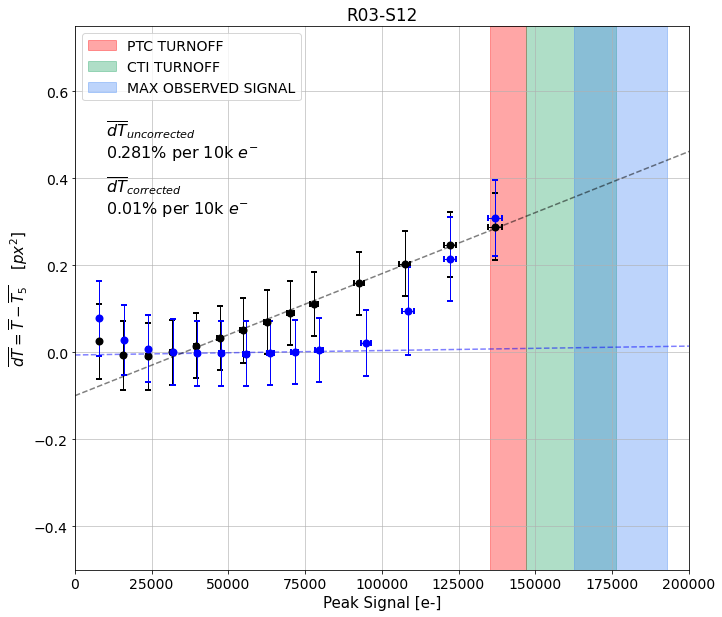

In [50]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
datale = data_corrected
exptimes = np.unique(data_corrected['exptime'])
#ref = data_corr[np.where(data_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="peakSignal"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in datale))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in datale:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    amps.extend(iterable["amps"])
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())

n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ax.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.35, color='red', label = "PTC TURNOFF")
ax.axvspan(np.min(cti_turnoffs), np.max(cti_turnoffs), alpha=0.35, color='#1aa260', label = "CTI TURNOFF")
ax.axvspan(np.min(mos), np.max(mos), alpha=0.35, color='#4285F4', label = "MAX OBSERVED SIGNAL")

array_aggregated_corrected = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx_corrected = []
fity_corrected = []


cond = np.argwhere((e==5.)&(y!=0))
T0_corrected = np.mean(iyy[cond] + ixx[cond])
T0err_corrected = np.std(iyy[cond] + ixx[cond])

for j, i in enumerate(exptimes):

    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)

    cond = np.argwhere((e==i)&(y!=0))
    #sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated_corrected = Aggregated()
    aggregated_corrected.e = np.mean(i)   
    aggregated_corrected.x = np.mean(x[cond])
    aggregated_corrected.y = np.mean(y[cond])
    aggregated_corrected.T = np.mean(ixx[cond] + iyy[cond])
    aggregated_corrected.xerr = np.std(x[cond])
    aggregated_corrected.yerr = np.std(ixx[cond] + iyy[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated_corrected.num = num
    aggregated_corrected.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated_corrected.append(aggregated)
    
    aggregated = array_aggregated[j]
    
    if aggregated_corrected.x <= np.min(cti_turnoffs):
        if i >= 5 and i < 14.:
            fitx_corrected.append(aggregated_corrected.x)
            fity_corrected.append(aggregated_corrected.T-T0_corrected)
        
        sca3=ax.errorbar(aggregated.x,aggregated.T-T0,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr + T0err,
                        fmt="o",color="k",mec="k",ecolor="k",alpha=1,
                        ms=6,mew=2, capsize=3, capthick=1, elinewidth=1)
        sca4=ax.errorbar(aggregated_corrected.x,aggregated_corrected.T-T0_corrected,
                        xerr=aggregated_corrected.xerr,
                        yerr=aggregated_corrected.yerr + T0err_corrected,
                        fmt="o", mfc="b",color="b",mec="b",ecolor="b",alpha=1,
                        ms=6,mew=2, capsize=3, capthick=1, elinewidth=1)

    


ax.set_ylabel("{}".format("$\overline{dT} = \overline{T}-\overline{T_{5}}\;\;\;\;[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [e-]", fontsize=15, y=-10)
ax.set_xlim(0,200000)
#ax.set_ylim(4.5,6.0)
#ax.set_ylim(4.,6.0)
#ax.set_ylim(.05,.45)
ax.set_ylim(-.5,0.75)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})
ax.grid(alpha=0.75)

m_corrected, b_corrected  = np.polyfit(fitx_corrected, fity_corrected, 1)
slope_corrected = m_corrected*100*1000
plt.text(10000.,.32,"{}".format(r"$\overline{dT}_{corrected}$") + "\n" + str(round(slope_corrected,3)) +"% per 10k $e^{-}$", fontsize=16)

ax.plot(np.linspace(0,5.5e6, 1000), m_corrected*np.linspace(0,5.5e6, 1000) + b_corrected, color="b" , linestyle="--", alpha=0.5)
x1_corrected = np.linspace(0,5.5e6, 1000)
y1_corrected = m_corrected*np.linspace(0,5.5e6, 1000) + b_corrected

m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
plt.text(10000.,.45,"{}".format(r"$\overline{dT}_{uncorrected}$") + "\n" + str(round(slope,3)) +"% per 10k $e^{-}$", fontsize=16)

ax.plot(np.linspace(0,5.5e6, 1000), m*np.linspace(0,5.5e6, 1000) + b, color="k" , linestyle="--", alpha=0.5)
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b



#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(loc=2)
        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

#cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
#cb = plt.colorbar(sca,cax=cbar_ax, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


#sca.set_clim(1.25,40)
#cb.set_label("Exposure time [s]", labelpad=10)
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title(sensor[0:3] + "-" + sensor[4:])
#plt.savefig("../plots/Ixx-uncorrected-450nm-R24_S11.png", bbox_inches='tight')